In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models
import json
import numpy as np
import pandas as pd

import os
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


DATASET_PATH = "resources/games/all_battles.json"
MODEL_EXPORT_PATH = "resources/models/"
SELECTED_PLAYERS = []
DISCOUNT_FACTOR = 0.98
EPOCHS = 20
BATCH_SIZE = 512
N_CORES = 8
LEARNING_RATE = 0.001

os.environ["OMP_NUM_THREADS"] = str(N_CORES)
os.environ["TF_NUM_INTRAOP_THREADS"] = str(N_CORES)
os.environ["TF_NUM_INTEROP_THREADS"] = str(N_CORES)

print("TensorFlow version:", tf.__version__)

#cuda fouten verbergen
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"



TensorFlow version: 2.20.0


In [10]:
def build_dataset(path):
    """
    CRITICAL FIX: Generate training data from BOTH players' perspectives.

    The key insight: In a two-player zero-sum game, we need to train the model
    to evaluate positions from a consistent perspective. We do this by:
    1. For each board position, create TWO training examples
    2. One from Light's perspective (original board, positive if Light wins)
    3. One from Dark's perspective (inverted board, positive if Dark wins)
    """
    with open(path) as f:
        data = json.load(f)

    print(f"Processing {len(data)} games")

    boards = []
    scores = []

    for game_idx, game in enumerate(data):
        # Skip games that don't have both players in the selected players list
        if SELECTED_PLAYERS and (
                game["lightPlayer"] not in SELECTED_PLAYERS or
                game["darkPlayer"] not in SELECTED_PLAYERS
        ):
            continue

        winner = game["winner"]  # 1 for Light, -1 for Dark
        n_moves = len(game["boardHistory"])
        reserve_size = game['reserveSize']

        for i, board_as_long in enumerate(game["boardHistory"]):
            # Convert board to array (0 = Light, 1 = Dark)
            board_as_array = np.array(
                [(board_as_long >> j) & 1 for j in range(59, -1, -1)],
                dtype=np.float32
            )

            # Calculate discount based on proximity to end of game
            # Positions closer to the end are more certain
            discount = DISCOUNT_FACTOR ** (n_moves - i - 1)

            # Light's perspective: positive if Light wins
            light_score = winner * discount * reserve_size
            boards.append(board_as_array)
            scores.append(light_score)

            # Dark's perspective: flip the board (0->1, 1->0) and score
            # This teaches the model to evaluate from the active player's view
            dark_board = 1.0 - board_as_array
            dark_score = -winner * discount * reserve_size  # Flip the score
            boards.append(dark_board)
            scores.append(dark_score)

        if game_idx % 1000 == 0:
            print(f"Processed game {game_idx}/{len(data)}")

    boards_array = np.array(boards, dtype=np.float32)
    scores_array = np.array(scores, dtype=np.float32)

    # Shuffle the dataset to mix Light and Dark perspectives
    indices = np.random.permutation(len(boards_array))

    return boards_array[indices], scores_array[indices]



In [11]:
def build_dense_model( units1=256, units2=128, units3=64, units4=32, dropout1=0.3, dropout2=0.3, dropout3=0.2, ):
     inputs = layers.Input(shape=(60,), dtype=tf.float32) 
     x = layers.Dense(units1, activation='relu')(inputs) 
     x = layers.BatchNormalization()(x)
     x = layers.Dropout(dropout1)(x) 
     x = layers.Dense(units2, activation='relu')(x) 
     x = layers.BatchNormalization()(x) 
     x = layers.Dropout(dropout2)(x)
     x = layers.Dense(units3, activation='relu')(x) 
     x = layers.BatchNormalization()(x)
     x = layers.Dropout(dropout3)(x) 
     x = layers.Dense(units4, activation='relu')(x) 
     x = layers.BatchNormalization()(x) 
     outputs = layers.Dense(1)(x) 
     model = models.Model(inputs=inputs, outputs=outputs) 
     return model 

In [12]:
def build_conv1d_model(
    filters1=32,
    filters2=64,
    kernel_size=3,
    dense_units1=64,
    dense_units2=32,
    dropout=0.3,
):
    inputs = layers.Input(shape=(60,), dtype=tf.float32)

    x = layers.Reshape((60, 1))(inputs)  # (batch, 60, 1)

    x = layers.Conv1D(filters1, kernel_size=kernel_size,
                      activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv1D(filters2, kernel_size=kernel_size,
                      activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.Flatten()(x)

    x = layers.Dense(dense_units1, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Dense(dense_units2, activation='relu')(x)
    x = layers.BatchNormalization()(x)

    outputs = layers.Dense(1)(x)

    model = models.Model(inputs=inputs, outputs=outputs)
    return model


In [13]:
def create_optimizer(name, learning_rate):
    name = name.lower()
    if name == "adam":
        return tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif name == "sgd":
        return tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    elif name == "rmsprop":
        return tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unknown optimizer name: {name}")


In [14]:
def train_single_experiment(
    model_builder,
    model_kwargs,
    optimizer_name,
    learning_rate,
    batch_size,
    X_train, y_train,
    X_val, y_val,
    X_test, y_test,
    label,
):
    print(f"\n==== Running experiment: {label} ====")
    print(f"Model kwargs: {model_kwargs}")
    print(f"Optimizer: {optimizer_name}, lr={learning_rate}, batch_size={batch_size}")

    model = model_builder(**model_kwargs)

    optimizer = create_optimizer(optimizer_name, learning_rate)

    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=["mae"]
    )

    callbacks = [
        tf.keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=2,
            min_lr=1e-6
        ),
    ]

    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=0  # maakt de output niet te spammy
    )

    test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

    print(f"Best val_loss: {min(history.history['val_loss']):.4f}")
    print(f"Best val_mae:  {min(history.history['val_mae']):.4f}")
    print(f"Test loss:     {test_loss:.4f}")
    print(f"Test MAE:      {test_mae:.4f}")

    result = {
        "label": label,
        "optimizer": optimizer_name,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "test_loss": test_loss,
        "test_mae": test_mae,
        "best_val_loss": float(min(history.history["val_loss"])),
        "best_val_mae": float(min(history.history["val_mae"])),
        "history": history.history,
    }

    return result


In [15]:


def run_experiments(X_train, y_train, X_val, y_val, X_test, y_test):
    experiments = []

    # 1) Dense modellen met verschillende groottes / batch sizes / optimizers
    experiments.append({
        "label": "dense_big_adam_bs512",
        "model_builder": build_dense_model,
        "model_kwargs": dict(units1=256, units2=128, units3=64, units4=32,
                             dropout1=0.3, dropout2=0.3, dropout3=0.2),
        "optimizer": "adam",
        "learning_rate": 0.001,
        "batch_size": 512,
    })

    experiments.append({
        "label": "dense_small_adam_bs256",
        "model_builder": build_dense_model,
        "model_kwargs": dict(units1=128, units2=64, units3=32, units4=16,
                             dropout1=0.3, dropout2=0.3, dropout3=0.2),
        "optimizer": "adam",
        "learning_rate": 0.001,
        "batch_size": 256,
    })

    experiments.append({
        "label": "dense_big_sgd_bs512",
        "model_builder": build_dense_model,
        "model_kwargs": dict(units1=256, units2=128, units3=64, units4=32,
                             dropout1=0.3, dropout2=0.3, dropout3=0.2),
        "optimizer": "sgd",
        "learning_rate": 0.01,
        "batch_size": 512,
    })

    # 2) Conv1D modellen met verschillende filters / kernel size
    experiments.append({
        "label": "conv1d_std_adam_bs512",
        "model_builder": build_conv1d_model,
        "model_kwargs": dict(filters1=32, filters2=64,
                             kernel_size=3,
                             dense_units1=64, dense_units2=32,
                             dropout=0.3),
        "optimizer": "adam",
        "learning_rate": 0.001,
        "batch_size": 512,
    })

    experiments.append({
        "label": "conv1d_wide_adam_bs256",
        "model_builder": build_conv1d_model,
        "model_kwargs": dict(filters1=64, filters2=128,
                             kernel_size=5,
                             dense_units1=128, dense_units2=64,
                             dropout=0.4),
        "optimizer": "adam",
        "learning_rate": 0.001,
        "batch_size": 256,
    })

    results = []

    for exp in experiments:
        res = train_single_experiment(
            model_builder=exp["model_builder"],
            model_kwargs=exp["model_kwargs"],
            optimizer_name=exp["optimizer"],
            learning_rate=exp["learning_rate"],
            batch_size=exp["batch_size"],
            X_train=X_train, y_train=y_train,
            X_val=X_val, y_val=y_val,
            X_test=X_test, y_test=y_test,
            label=exp["label"],
        )
        results.append(res)

    # tabelletje met overzicht
    df = pd.DataFrame([
        {
            "label": r["label"],
            "optimizer": r["optimizer"],
            "lr": r["learning_rate"],
            "batch_size": r["batch_size"],
            "best_val_loss": r["best_val_loss"],
            "best_val_mae": r["best_val_mae"],
            "test_loss": r["test_loss"],
            "test_mae": r["test_mae"],
        }
        for r in results
    ])

    print("\n==================== RESULT TABLE ====================")
    print(df.sort_values("test_mae"))

    # plots maken
    plot_metric_histories(results, metric="mae")
    plot_metric_histories(results, metric="loss")

    return results, df


In [16]:
def plot_metric_histories(results, metric="mae"):
    plt.figure()
    for r in results:
        h = r["history"]
        if metric not in h:
            continue
        plt.plot(h[metric], linestyle="-", label=f"{r['label']} - train")
        val_key = f"val_{metric}"
        if val_key in h:
            plt.plot(h[val_key], linestyle="--", label=f"{r['label']} - val")

    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.title(f"{metric} per epoch")
    plt.legend()
    plt.grid(True)
    plt.show()


TensorFlow version: 2.20.0
Loading dataset...
Processing 12000 games
Processed game 0/12000
Processed game 1000/12000
Processed game 2000/12000
Processed game 3000/12000
Processed game 4000/12000
Processed game 5000/12000
Processed game 6000/12000
Processed game 7000/12000
Processed game 8000/12000
Processed game 9000/12000
Processed game 10000/12000
Processed game 11000/12000
Train size: 581664
Val size:   145415
Test size:  181769

==== Running experiment: dense_big_adam_bs512 ====
Model kwargs: {'units1': 256, 'units2': 128, 'units3': 64, 'units4': 32, 'dropout1': 0.3, 'dropout2': 0.3, 'dropout3': 0.2}
Optimizer: adam, lr=0.001, batch_size=512


I0000 00:00:1763065517.043089   97302 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2003 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
2025-11-13 21:25:36.789627: I external/local_xla/xla/service/service.cc:163] XLA service 0x7017c40072c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-13 21:25:36.789661: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-11-13 21:25:36.825800: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-13 21:25:37.092676: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500
2025-11-13 21:25:37.236194: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs wer

Best val_loss: 1.4091
Best val_mae:  0.9394
Test loss:     1.4095
Test MAE:      0.9379

==== Running experiment: dense_small_adam_bs256 ====
Model kwargs: {'units1': 128, 'units2': 64, 'units3': 32, 'units4': 16, 'dropout1': 0.3, 'dropout2': 0.3, 'dropout3': 0.2}
Optimizer: adam, lr=0.001, batch_size=256


2025-11-13 21:30:18.051879: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-13 21:30:18.051948: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-13 21:30:18.051958: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-13 21:30:18.051985: I external/l

Best val_loss: 1.5287
Best val_mae:  0.9897
Test loss:     1.5280
Test MAE:      0.9896

==== Running experiment: dense_big_sgd_bs512 ====
Model kwargs: {'units1': 256, 'units2': 128, 'units3': 64, 'units4': 32, 'dropout1': 0.3, 'dropout2': 0.3, 'dropout3': 0.2}
Optimizer: sgd, lr=0.01, batch_size=512


2025-11-13 21:37:56.261544: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-13 21:37:57.119915: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2191', 80 bytes spill stores, 80 bytes spill loads

2025-11-13 21:37:57.546451: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_2191', 1064 bytes spill stores, 1064 bytes spill loads

2025-11-13 21:38:08.127396: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hint

Best val_loss: 1.4496
Best val_mae:  0.9559
Test loss:     1.4499
Test MAE:      0.9561

==== Running experiment: conv1d_std_adam_bs512 ====
Model kwargs: {'filters1': 32, 'filters2': 64, 'kernel_size': 3, 'dense_units1': 64, 'dense_units2': 32, 'dropout': 0.3}
Optimizer: adam, lr=0.001, batch_size=512


2025-11-13 21:42:25.809618: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1808', 1064 bytes spill stores, 1064 bytes spill loads

2025-11-13 21:42:27.379843: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng26{k2=1,k4=1,k5=1,k6=0,k7=0,k19=1} for conv (f32[512,32,1,60]{3,2,1,0}, u8[0]{0}) custom-call(f32[512,64,1,60]{3,2,1,0}, f32[64,32,1,3]{3,2,1,0}), window={size=1x3 pad=0_0x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardInput", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-11-13 21:42:29.202487: E external/local_xla/xla/service/slow_operation_alarm.cc:140] The operation took 2.822745788s
Tryin

Best val_loss: 1.3985
Best val_mae:  0.9396
Test loss:     1.3919
Test MAE:      0.9360

==== Running experiment: conv1d_wide_adam_bs256 ====
Model kwargs: {'filters1': 64, 'filters2': 128, 'kernel_size': 5, 'dense_units1': 128, 'dense_units2': 64, 'dropout': 0.4}
Optimizer: adam, lr=0.001, batch_size=256


2025-11-13 21:47:57.571279: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1808', 80 bytes spill stores, 80 bytes spill loads

2025-11-13 21:48:30.676180: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-11-13 21:48:31.467472: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1808', 520 bytes spill stores, 520 bytes spill loads

2025-11-13 21:48:37.118308: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng11{k2=4,k3=0} for conv (f32[32,64,1,60]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,1,1,60]{3,

Best val_loss: 1.1522
Best val_mae:  0.8339
Test loss:     1.1536
Test MAE:      0.8343

==================== RESULT TABLE ====================
                    label optimizer     lr  batch_size  best_val_loss  \
4  conv1d_wide_adam_bs256      adam  0.001         256       1.152200   
3   conv1d_std_adam_bs512      adam  0.001         512       1.398457   
0    dense_big_adam_bs512      adam  0.001         512       1.409077   
2     dense_big_sgd_bs512       sgd  0.010         512       1.449554   
1  dense_small_adam_bs256      adam  0.001         256       1.528741   

   best_val_mae  test_loss  test_mae  
4      0.833873   1.153598  0.834343  
3      0.939575   1.391911  0.935966  
0      0.939446   1.409459  0.937947  
2      0.955938   1.449919  0.956140  
1      0.989720   1.527972  0.989589  


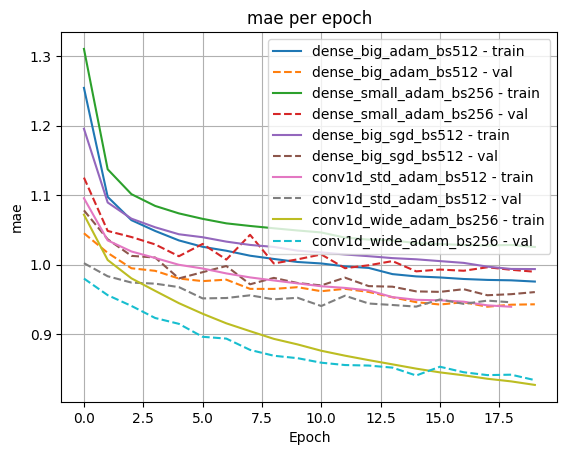

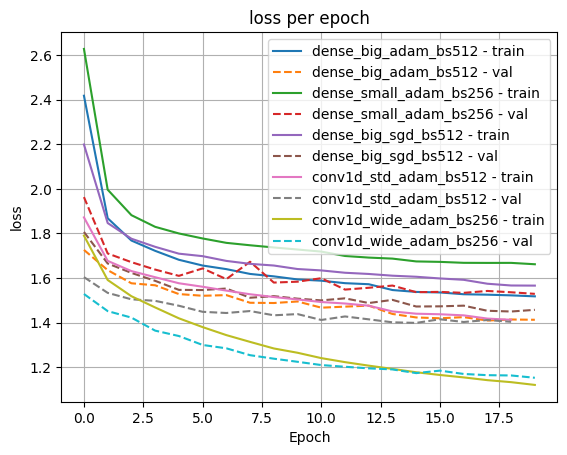


Best experiment based on test MAE:
label            conv1d_wide_adam_bs256
optimizer                          adam
lr                                0.001
batch_size                          256
best_val_loss                    1.1522
best_val_mae                   0.833873
test_loss                      1.153598
test_mae                       0.834343
Name: 4, dtype: object


In [17]:
print("TensorFlow version:", tf.__version__)
print("Loading dataset...")

boards, scores = build_dataset(DATASET_PATH)

# ---- Train / Val / Test split ----
N = len(boards)
test_size = int(N * 0.2)
val_size  = int((N - test_size) * 0.2)

X_test = boards[:test_size]
y_test = scores[:test_size]

X_trainval = boards[test_size:]
y_trainval = scores[test_size:]

X_val = X_trainval[:val_size]
y_val = y_trainval[:val_size]

X_train = X_trainval[val_size:]
y_train = y_trainval[val_size:]

print(f"Train size: {len(X_train)}")
print(f"Val size:   {len(X_val)}")
print(f"Test size:  {len(X_test)}")

# hyperparameter search
results, df = run_experiments(X_train, y_train, X_val, y_val, X_test, y_test)

# eventueel: beste config tonen
best_row = df.sort_values("test_mae").iloc[0]
print("\nBest experiment based on test MAE:")
print(best_row)